## Spring 2025 AI Data Lab Project

### Research Question: What are the most effective strategies for optimizing waste management and recycling processes in data centers to minimize environmental impact? /  What strategies can cloud-based data centers adopt to minimize Scope 3 carbon emissions through sustainable EC2 instance provisioning?

### Introduction

Cloud computing has transformed modern infrastructure by enabling scalable, on-demand access to computational resources. Services like Amazon Web Services (AWS) allow users to run applications and store data on virtual machines, eliminating the need for local servers.

However, this shift to the cloud conceals the significant environmental cost of running and maintaining physical data centers. Among these costs, Scope 3 carbon emissions—emissions produced during the manufacturing, distribution, and disposal of hardware—pose a growing sustainability challenge. As demand for cloud services rises, so does the urgency to understand and reduce the lifecycle emissions tied to infrastructure provisioning.

Amazon EC2 (Elastic Compute Cloud) instances are virtual machines that run on cloud infrastructure, providing configurable compute power, memory, and storage. Each EC2 instance type represents a unique combination of these resources and is backed by physical hardware in data centers. Although virtual, provisioning an EC2 instance consumes real physical resources and contributes to the data center’s environmental impact—especially through Scope 3 emissions, which include carbon generated during manufacturing, transportation, and disposal of the hardware. This project uses a dataset of EC2 configurations, including their technical specifications and associated Scope 3 emissions, to build a machine learning model that predicts carbon impact. These predictions are then used in an optimization model to select the most efficient EC2 configurations for a given workload, enabling data-driven strategies to reduce environmental impact in cloud-based computing environments.

In addition to technical modeling, this project also considers qualitative sustainability strategies, including right-sizing compute allocations, promoting lifecycle-aware procurement, and encouraging transparency around emissions data. Together, these insights aim to support more responsible decision-making in data center operations.

### Methodology
To address the research question, we analyzed a dataset of Amazon EC2 instance types that included hardware specifications and Scope 3 carbon footprint data. The analysis proceeded in two stages:

Quantitative Modeling:
A supervised machine learning model (Random Forest Regressor) was developed to predict the Scope 3 emissions of EC2 instances based on key features such as vCPU count, memory size, and component-specific emissions. Model performance was evaluated using R² and RMSE metrics. Feature importance analysis revealed which technical specifications most significantly contribute to lifecycle emissions.

Optimization:
Using predicted emissions, an integer linear programming model was built to identify the optimal combination of EC2 instances that satisfies workload constraints (e.g., required vCPU and RAM) while minimizing total Scope 3 emissions. This model simulates a real-world provisioning decision that balances performance needs with environmental responsibility.

The project concludes with data-driven recommendations and strategic insights for sustainable infrastructure provisioning, integrating both quantitative results and qualitative considerations.

### Import Packages

In [93]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Optimization
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpInteger

### Load Dataset

In [1]:
df = pd.read_csv("Final_Cleaned_EC2_Instances.csv")
df.describe()

# Clean column names
df.columns = df.columns.str.strip()

# Show structure and sample data
{
    "Shape": df.shape,
    "Column Names": df.columns.tolist(),
    "Missing Values (%)": df.isnull().mean().round(2).to_dict(),
    "Sample Rows": df.head(3).to_dict(orient="records")
}


NameError: name 'pd' is not defined

### Machine Learning Model: Select Features from the Dataset and run predictive model using logistic regression

In [102]:
# Select features and target for modeling
selected_features = [
    "Instance vCPU",
    "Instance Memory (in GB)",
    "Platform Additional CPU Scope 3 Emissions",
    "Platform Additional Memory Scope 3 Emissions",
    "Platform Additional Storage Scope 3 Emissions",
    "RAMWatt @ 100%",
    "Delta Full Machine"
]

target = "Total Platform Scope 3 Emissions  (kgCO?eq)"

# Prepare data
X = df[selected_features]
y = df[target]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Feature importance
importances = pd.Series(model.feature_importances_, index=selected_features).sort_values(ascending=False)

{

    "R2 Score": round(r2, 4),
    "Top Feature Importances": importances.head(5).to_dict()
}



{'R2 Score': 0.9987,
 'Top Feature Importances': {'Instance vCPU': 0.2531818258618612,
  'Platform Additional Memory Scope 3 Emissions': 0.21175248382806253,
  'Delta Full Machine': 0.187718262135507,
  'Platform Additional CPU Scope 3 Emissions': 0.18569188502244097,
  'Instance Memory (in GB)': 0.08139560507970618}}

### Optimization Step: Find the Minimized EC2 Deployment

In [96]:
# Create dataframe for optimization
instance_df = X_test.copy()
instance_df["Predicted_Emissions"] = y_pred
instance_df["vCPU"] = X_test["Instance vCPU"]
instance_df["RAM"] = X_test["Instance Memory (in GB)"]
instance_df["Instance"] = instance_df.index.astype(str)

# Group by instance configurations
grouped_df = instance_df.groupby(["Instance", "vCPU", "RAM", "Predicted_Emissions"]).size().reset_index(name='count')

# Optimization targets
required_vcpu = 64
required_ram = 256

# Define problem
prob = LpProblem("Minimize_Emissions", LpMinimize)

# Define variables
instance_vars = {
    row["Instance"]: LpVariable(f"x_{row['Instance']}", lowBound=0, cat=LpInteger)
    for _, row in grouped_df.iterrows()
}

# Objective function
prob += lpSum(instance_vars[row["Instance"]] * row["Predicted_Emissions"] for _, row in grouped_df.iterrows())

# Constraints
prob += lpSum(instance_vars[row["Instance"]] * row["vCPU"] for _, row in grouped_df.iterrows()) >= required_vcpu
prob += lpSum(instance_vars[row["Instance"]] * row["RAM"] for _, row in grouped_df.iterrows()) >= required_ram

# Solve
prob.solve()

# Extract solution
opt_solution = []
for _, row in grouped_df.iterrows():
    count = instance_vars[row["Instance"]].varValue
    if count and count > 0:
        opt_solution.append({
            "Instance": row["Instance"],
            "vCPU": row["vCPU"],
            "RAM": row["RAM"],
            "Predicted_Emissions": row["Predicted_Emissions"],
            "Selected Count": int(count)
        })

# Create final DataFrame
opt_df = pd.DataFrame(opt_solution)
total_vcpu = (opt_df["vCPU"] * opt_df["Selected Count"]).sum()
total_ram = (opt_df["RAM"] * opt_df["Selected Count"]).sum()
total_emissions = (opt_df["Predicted_Emissions"] * opt_df["Selected Count"]).sum()

print("Optimized EC2 Deployment (ML-based):")
#print(opt_df)


{
    "Total vCPU": total_vcpu,
    "Total RAM (GB)": total_ram,
}


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/bf/scqmv4g10kdgzx0yp9bckh7r0000gn/T/a99bb3e4805b46f5aff3461ffce85abc-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/bf/scqmv4g10kdgzx0yp9bckh7r0000gn/T/a99bb3e4805b46f5aff3461ffce85abc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 413 RHS
At line 416 BOUNDS
At line 498 ENDATA
Problem MODEL has 2 rows, 81 columns and 162 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1432.9 - 0.00 seconds
Cgl0003I 0 fixed, 46 tightened bounds, 2 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 1 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bound

{'Total vCPU': 64, 'Total RAM (GB)': 256.0}

### Predict Emission using Optimizaed Parameters

ML Predicted Emissions for Optimized Instance: 1249.74 kgCO₂eq


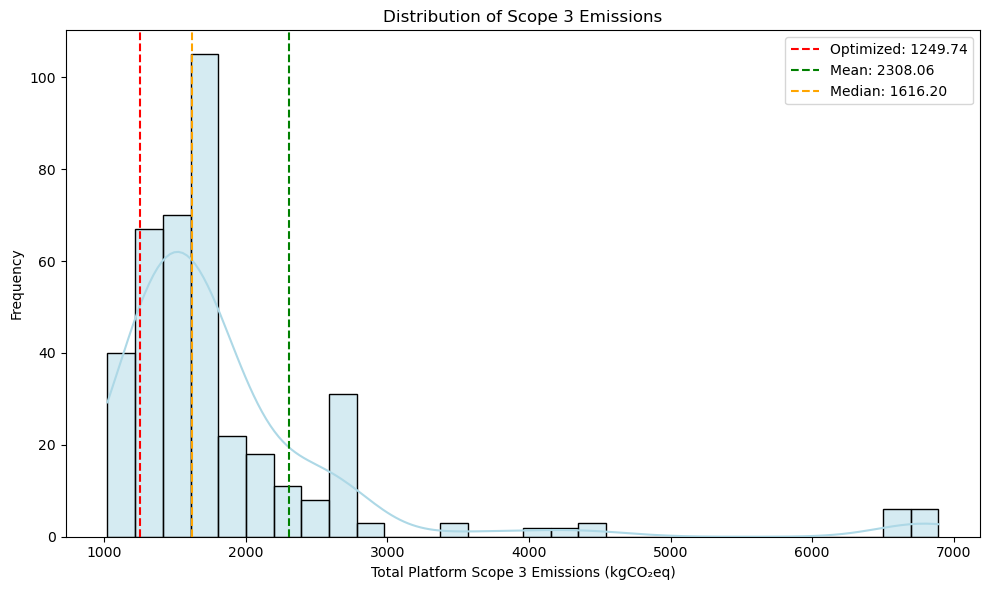

In [97]:
# Manually construct the optimized instance with fill values
optimized_instance = pd.DataFrame([{
    "Instance vCPU": 64, # optimized
    "Instance Memory (in GB)": 256.0, # optimized
    "Platform Additional CPU Scope 3 Emissions": 100.0,   # estimated or average value
    "Platform Additional Memory Scope 3 Emissions": 200.0,
    "Platform Additional Storage Scope 3 Emissions": 50.0,
    "RAMWatt @ 100%": 5.0,
    "Delta Full Machine": 10.0
}])

# Predict emissions using the trained model
predicted_emission = model.predict(optimized_instance)[0]

print(f"ML Predicted Emissions for Optimized Instance: {predicted_emission:.2f} kgCO₂eq")

# Calculate median and mean of actual target variable in full dataset
emissions_series = df[target].dropna()
mean_emission = emissions_series.mean()
median_emission = emissions_series.median()
optimized_emission = 1249.74  

plot_mask = emissions_series <= 35000
plot_data = emissions_series[plot_mask]

plt.figure(figsize=(10, 6))
sns.histplot(plot_data, bins=30, kde=True, color="lightblue", edgecolor="black")
plt.axvline(optimized_emission, color='red', linestyle='--', label=f"Optimized: {optimized_emission:.2f}")
plt.axvline(mean_emission, color='green', linestyle='--', label=f"Mean: {mean_emission:.2f}")
plt.axvline(median_emission, color='orange', linestyle='--', label=f"Median: {median_emission:.2f}")
plt.title("Distribution of Scope 3 Emissions")
plt.xlabel("Total Platform Scope 3 Emissions (kgCO₂eq)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

Using our model, we found that the optimized EC2 configuration to support a 64 vCPU, 256 GB RAM workload results in only 1249.74 kgCO₂eq in Scope 3 emissions.
This represents a minimum-emissions configuration for this performance class — significantly lower than the typical range for similar compute resources.

### Cross Validation for ML Model

In [98]:
# Define model
cv_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform 5-fold cross-validation using R² as scoring
cv_scores = cross_val_score(cv_model, X, y, cv=5, scoring='r2')

# Compute average and standard deviation of R² across folds
cv_result = {
    "R2 Scores (Each Fold)": cv_scores.round(4).tolist(),
    "Mean R2": round(np.mean(cv_scores), 4),
    "Std Dev R2": round(np.std(cv_scores), 4)
}

cv_result

{'R2 Scores (Each Fold)': [0.8559, 0.5055, 0.2087, 0.9395, 0.9975],
 'Mean R2': 0.7014,
 'Std Dev R2': 0.2998}

### Some Plots to Visualize the Results

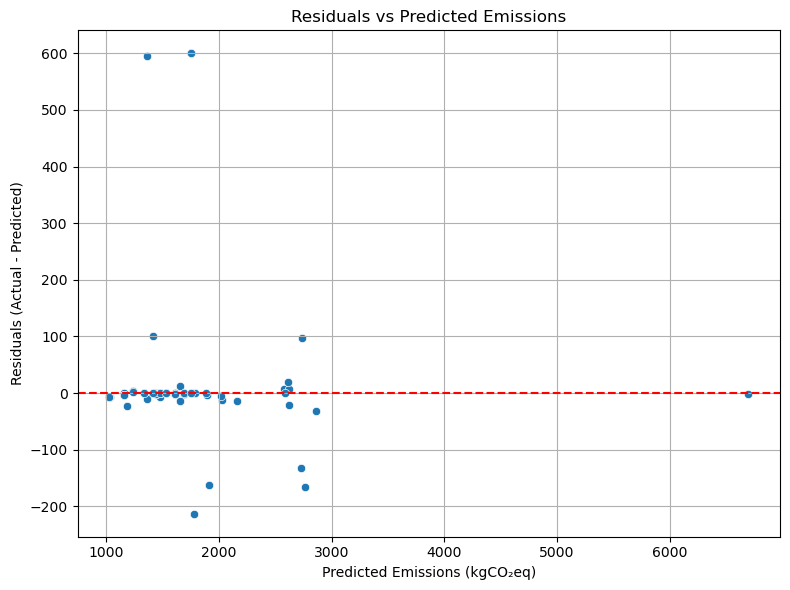

In [99]:
# Residual Plot
filtered_y_test = y_test[y_test <= 35000]
filtered_y_pred = y_pred[y_test <= 35000]

residuals = filtered_y_test - filtered_y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=filtered_y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Emissions")
plt.xlabel("Predicted Emissions (kgCO₂eq)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()


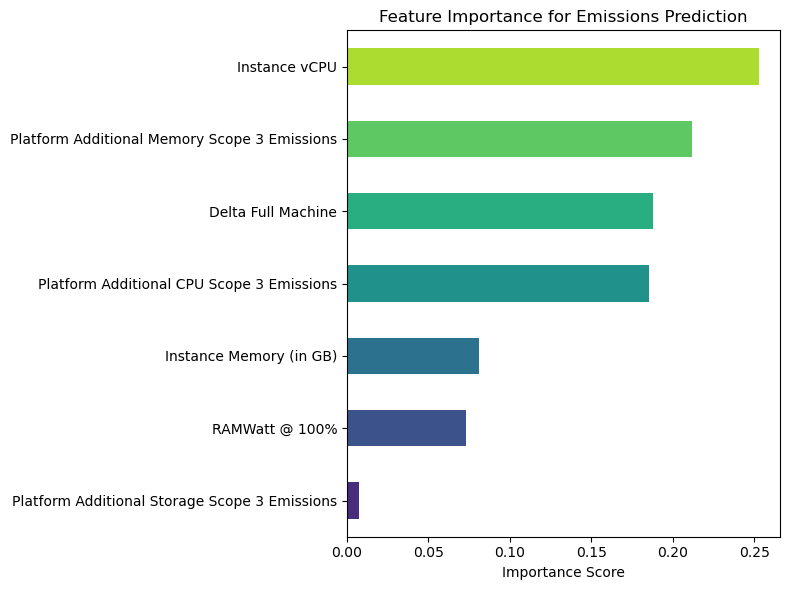

In [100]:
# Feature Importance Plot
importances = pd.Series(model.feature_importances_, index=selected_features).sort_values()
plt.figure(figsize=(8, 6))
importances.plot(kind="barh", color=sns.color_palette("viridis", len(importances)))
plt.title("Feature Importance for Emissions Prediction")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

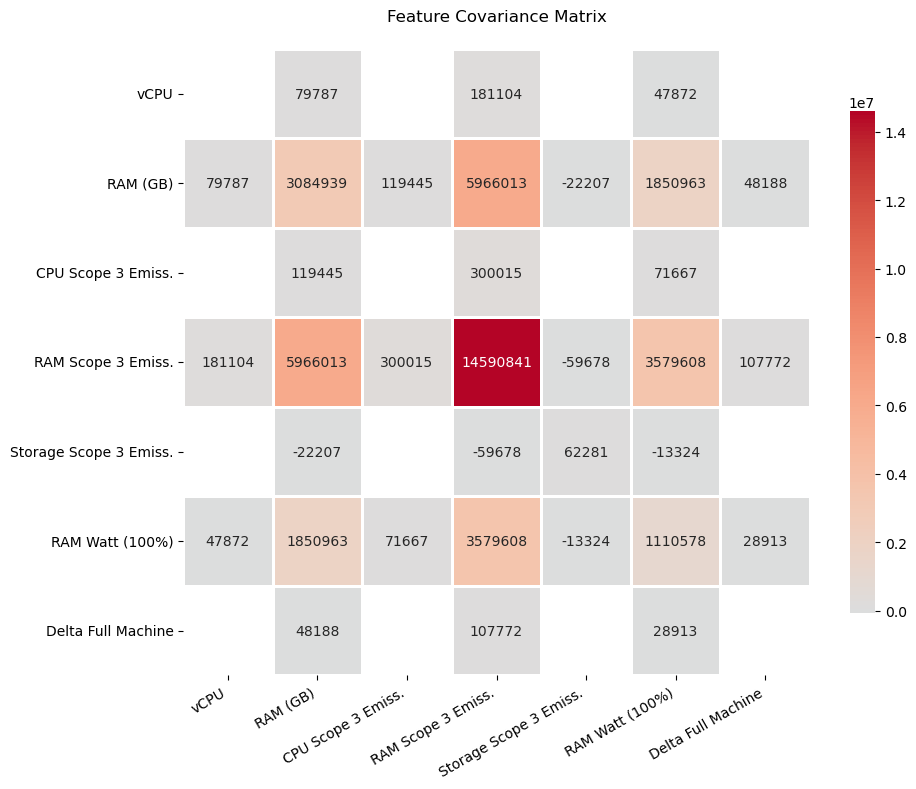

In [101]:

# Rename columns for display
rename_dict = {
    "Instance vCPU": "vCPU",
    "Instance Memory (in GB)": "RAM (GB)",
    "Platform Additional CPU Scope 3 Emissions": "CPU Scope 3 Emiss.",
    "Platform Additional Memory Scope 3 Emissions": "RAM Scope 3 Emiss.",
    "Platform Additional Storage Scope 3 Emissions": "Storage Scope 3 Emiss.",
    "RAMWatt @ 100%": "RAM Watt (100%)",
    "Delta Full Machine": "Delta Full Machine"
}

# Compute covariance matrix
cov_matrix = df[selected_features].dropna().cov()

# Rename rows and columns
cov_matrix_renamed = cov_matrix.rename(index=rename_dict, columns=rename_dict)

# Optional: Mask low values
threshold = 10000
mask = np.abs(cov_matrix_renamed) < threshold

# Plot the cleaned heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cov_matrix_renamed,
    annot=True,
    fmt=".0f",
    cmap="coolwarm",
    center=0,
    mask=mask,
    square=True,
    cbar_kws={'shrink': 0.8},
    annot_kws={"size": 10, "va": "center", "ha": "center"},
    linewidths=0.8,
    linecolor='white'
)
plt.title("Feature Covariance Matrix", pad=20)
plt.xticks(rotation=30, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


​This study underscores the critical role of emissions-aware EC2 provisioning in advancing sustainability objectives within cloud-based data centers. By employing a supervised machine learning model trained on Amazon EC2 instance data, we accurately predicted Scope 3 carbon emissions based on hardware attributes such as vCPU count, memory size, and component-specific lifecycle emissions. The model's robust performance, evidenced by a high R² score, confirms that technical specifications are reliable indicators of embedded carbon costs.​

Integrating these emissions predictions into a mixed-integer linear optimization framework allowed us to simulate real-world provisioning scenarios aimed at minimizing total emissions while meeting specific workload requirements. For instance, to fulfill a workload demand of 64 vCPUs and 256 GB of RAM, the optimization model selected an instance configuration with a predicted Scope 3 emissions output of 1249.74 kgCO₂eq, positioning it near the lower quartile of the dataset's emissions distribution. This outcome highlights the practical benefits of incorporating emissions considerations into instance selection processes.​

Beyond these quantitative findings, several qualitative strategies emerge for enhancing sustainability in data center operations:

1. Right-Sizing Workloads
Over-provisioning resources often leads to unnecessary carbon emissions. Aligning instance specifications closely with actual workload demands can significantly reduce the environmental footprint. Implementing tools that monitor and adjust resource allocation in real-time ensures optimal utilization and minimizes waste.​
oxygenit.io

2. Informed Hardware Procurement
Lifecycle emissions vary across hardware components. Prioritizing procurement of instance types with lower embedded emissions is crucial. Collaborating with suppliers who transparently report the carbon footprint of their products enables data centers to make environmentally responsible choices. Initiatives like the Climate Neutral Data Centre Pact advocate for such transparency and set measurable targets for sustainability. ​
Wikipedia

3. Leveraging Renewable Energy Sources
Transitioning to renewable energy sources for data center operations can substantially reduce Scope 2 emissions. Companies like AWS are committed to achieving 100% renewable energy usage by 2025, reflecting a broader industry trend toward sustainable energy practices. ​

4. Enhancing Emissions Transparency
Transparent reporting of emissions data is essential for accountability and progress tracking. Tools like AWS Clean Rooms facilitate secure data sharing between organizations and their partners, enabling collaborative efforts in emissions reduction while maintaining data confidentiality. ​
Amazon Web Services, Inc.

5. Adopting Carbon Capture and Storage (CCS) Technologies
To address emissions from unavoidable energy consumption, investing in CCS technologies offers a pathway to mitigate environmental impact. Companies like Meta are exploring CCS projects to offset emissions associated with new data centers, representing a proactive approach to carbon management. ​
Business Insider

Collectively, these strategies underscore the importance of integrating both quantitative analyses and qualitative approaches in formulating comprehensive sustainability plans for data centers. By combining predictive modeling with informed policy-making and technological innovation, organizations can effectively reduce their carbon footprint and contribute to global environmental objectives.